In [8]:
import os
import sys
from pathlib import Path
import torch
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import cv2
import random

In [9]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.models.model import get_model
from src.predict import predict
from src.utils.colorize import colorize_mask, create_overlay

In [10]:
LATEST_EVAL = sorted(os.listdir("../eval"))[-1]
EVAL_PATH = os.path.join("../eval", LATEST_EVAL)
train_log_path = os.path.join(EVAL_PATH, "training_log.csv")
cm_path = os.path.join(EVAL_PATH, "confusion_matrix.npy")
iou_path = os.path.join(EVAL_PATH, "per_class_iou.csv")
summary_path = os.path.join(EVAL_PATH, "summary_metrics.json")
mask_dir = "../data/processed/labels/val"

In [29]:
EVAL_TIMESTAMP = EVAL_PATH[-15:]
EVAL_TIMESTAMP

'01-27-2026-1352'

In [20]:
classes = ['road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
           'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car',
           'truck', 'bus', 'train', 'motorcycle', 'bicycle']
dist_df = calculate_class_distribution(mask_dir, classes)

Analyzing 1000 masks for pixel distribution...


100%|██████████████████████████████████████| 1000/1000 [00:04<00:00, 242.20it/s]


In [14]:
def plot_training_logs(log_path):
    df = pd.read_csv(log_path)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # --- Plot Loss ---
    ax1.plot(df['epoch'], df['train_loss'], label='Train Loss', color='blue', linewidth=2)
    ax1.plot(df['epoch'], df['val_loss'], label='Val Loss', color='red', linestyle='--', linewidth=2)
    ax1.set_title('Training & Validation Loss', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- Plot mIoU ---
    # Assuming you tracked validation mIoU
    ax2.plot(df['epoch'], df['train_miou'], label='Train mIoU', color='blue', linewidth=2)
    ax2.plot(df['epoch'], df['val_miou'], label='Val mIoU', color='red', linewidth=2)
    ax2.set_title('Validation mIoU Over Time', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('mIoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [46]:
def plot_iou(iou_path):
    iou_df = pd.read_csv(iou_path)
    iou_df_sorted = iou_df.sort_values(by="iou", ascending=False)
    plt.figure(figsize=(12, 8))
    
    colors = sns.color_palette("viridis", len(iou_df_sorted))
    sns.barplot(x='iou', y='class_name', hue='class_name', data=iou_df_sorted, palette=colors)
    
    # vertical line for mean iou
    miou = iou_df_sorted['iou'].mean()
    plt.axvline(miou, color='red', linestyle='--', label=f'Mean IoU: {miou:.4f}')
    
    plt.title('Per-Class IoU Performance (BDD10K)', fontsize=15)
    plt.xlabel('Intersection over Union (IoU)', fontsize=12)
    plt.ylabel('Class', fontsize=12)
    plt.xlim(0, 1) # iou is between 0 and 1
    plt.legend()
    plt.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('per_class_iou_chart.png')
    plt.show()
    return iou_df_sorted

In [16]:
def plot_confusion_matrix(cm_path, classes):
    cm = np.load(cm_path)
    
    # Normalize by row (true labels)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm = np.nan_to_num(cm_norm) # handle division by zero

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm_norm, annot=False, fmt=".2f", cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    
    plt.title('Normalized Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.tight_layout()
    plt.show()

In [17]:
def plot_error_heatmap(gt, pred):
    error_map = np.zeros((*gt.shape, 3), dtype=np.uint8)
    
    # Correct predictions (Green)
    error_map[(gt == pred) & (gt > 0)] = [0, 255, 0] 
    # False Negatives (Red - missed it)
    error_map[(gt != pred) & (gt > 0)] = [255, 0, 0]
    # False Positives (Blue - hallucinated)
    error_map[(gt != pred) & (pred > 0)] = [0, 0, 255]
    
    plt.imshow(error_map)
    plt.title("Error Heatmap: Green=Correct, Red=Missed, Blue=Wrong Prediction")
    plt.show()

In [18]:
def calculate_class_distribution(mask_dir, classes):
    num_classes = len(classes)
    counts = np.zeros(len(classes), dtype=np.int64)
    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]
    
    print(f"Analyzing {len(mask_files)} masks for pixel distribution...")
    for filename in tqdm(mask_files):
        mask = cv2.imread(os.path.join(mask_dir, filename), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            # count occurrences of each class ID (0-18)
            counts += np.bincount(mask.flatten(), minlength=len(classes))[:num_classes]
            
    # Calculate percentage
    total_pixels = counts.sum()
    percentages = (counts / total_pixels) * 100
    
    return pd.DataFrame({
        'class_name': classes,
        'pixel_count': counts,
        'percentage': percentages
    })

In [19]:
def plot_distribution_vs_iou(dist_df, iou_df):
    # Merge the dataframes on class name
    merged = pd.merge(dist_df, iou_df, on='class_name')
    
    fig, ax1 = plt.subplots(figsize=(14, 7))

    # --- Bar Chart for Pixel Percentage ---
    sns.barplot(data=merged, x='class_name', y='percentage', alpha=0.6, color='gray', ax=ax1, label='Pixel % in Dataset')
    ax1.set_ylabel('Percentage of Total Pixels (%)', fontsize=12)
    # ax1.set_yscale('log') # Use log scale because Road/Sky dwarf everything else
    plt.xticks(rotation=45)

    # --- Line Plot for IoU ---
    ax2 = ax1.twinx() # Create a second Y-axis
    sns.lineplot(data=merged, x='class_name', y='iou', marker='o', color='red', linewidth=3, ax=ax2, label='IoU Score')
    ax2.set_ylabel('IoU Score', color='red', fontsize=12)
    ax2.set_ylim(0, 1)

    plt.title('Dataset Bias: Class Frequency vs. Model Performance', fontsize=15)
    ax1.grid(axis='y', alpha=0.3)
    plt.show()

In [32]:
image_dir = "../data/processed/images/val"
color_label_dir = "../data/processed/color_labels/val"
pred_dir = f"../preds/val/masks_{EVAL_TIMESTAMP}"

In [33]:
dims = set()
for img_name in os.listdir(image_dir):
    path = os.path.join(image_dir, img_name)
    img = cv2.imread(path)
    if img.shape[0] == 1280:
        print(path)
    dims.add(img.shape)

../data/processed/images/val/9342e334-33d167eb.jpg
../data/processed/images/val/80a9e37d-e4548ac1.jpg


In [34]:
dims

{(720, 1280, 3), (1280, 720, 3)}

In [38]:
def display_predictions(pred_dir, image_dir, color_label_dir, num_samples=8):
    all_img_names = sorted([f for f in os.listdir(image_dir) if f.endswith(".jpg")])
    num_samples = min(num_samples, len(all_img_names))
    img_names = random.sample(all_img_names, num_samples)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 5 * num_samples), squeeze=False)
    alpha = 0.99

    for i in range(num_samples):
        img_name = img_names[i]
        img_stem = Path(img_name).stem

        # 1. Load original image and get its SPECIFIC shape
        img_path = os.path.join(image_dir, img_name)
        img_bgr = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        
        # DYNAMIC DIMENSIONS: This fixes the "Tall vs Wide" crash
        h_orig, w_orig = img_rgb.shape[:2]

        # 2. Load and resize prediction
        pred_path = os.path.join(pred_dir, f"{img_stem}.png")
        pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

        # Upscale to the current image's resolution
        pred_mask_full_res = cv2.resize(
            pred_mask.astype(np.uint8),
            (w_orig, h_orig), # OpenCV uses (width, height)
            interpolation=cv2.INTER_NEAREST
        )
        pred_color = colorize_mask(pred_mask_full_res)
        pred_display = create_overlay(img_rgb, pred_color, alpha=alpha)

        # 3. Load and ensure Ground Truth matches current shape
        gt_path = os.path.join(color_label_dir, f"{img_stem}_train_color.png") 
        gt_bgr = cv2.imread(gt_path)
        gt_rgb = cv2.cvtColor(gt_bgr, cv2.COLOR_BGR2RGB)
        if gt_rgb.shape[:2] != (h_orig, w_orig):
            gt_rgb = cv2.resize(gt_rgb, (w_orig, h_orig), interpolation=cv2.INTER_NEAREST)
        
        # 4. Plotting (axes[i, j] now works even for 1 sample)
        axes[i, 0].imshow(img_rgb)
        axes[i, 0].set_title(f"Image: {img_name}")
        
        axes[i, 1].imshow(gt_rgb)
        axes[i, 1].set_title("Ground Truth (Labels)")
        
        axes[i, 2].imshow(pred_display)
        axes[i, 2].set_title(f"Prediction Overlay")

        for ax in axes[i]:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

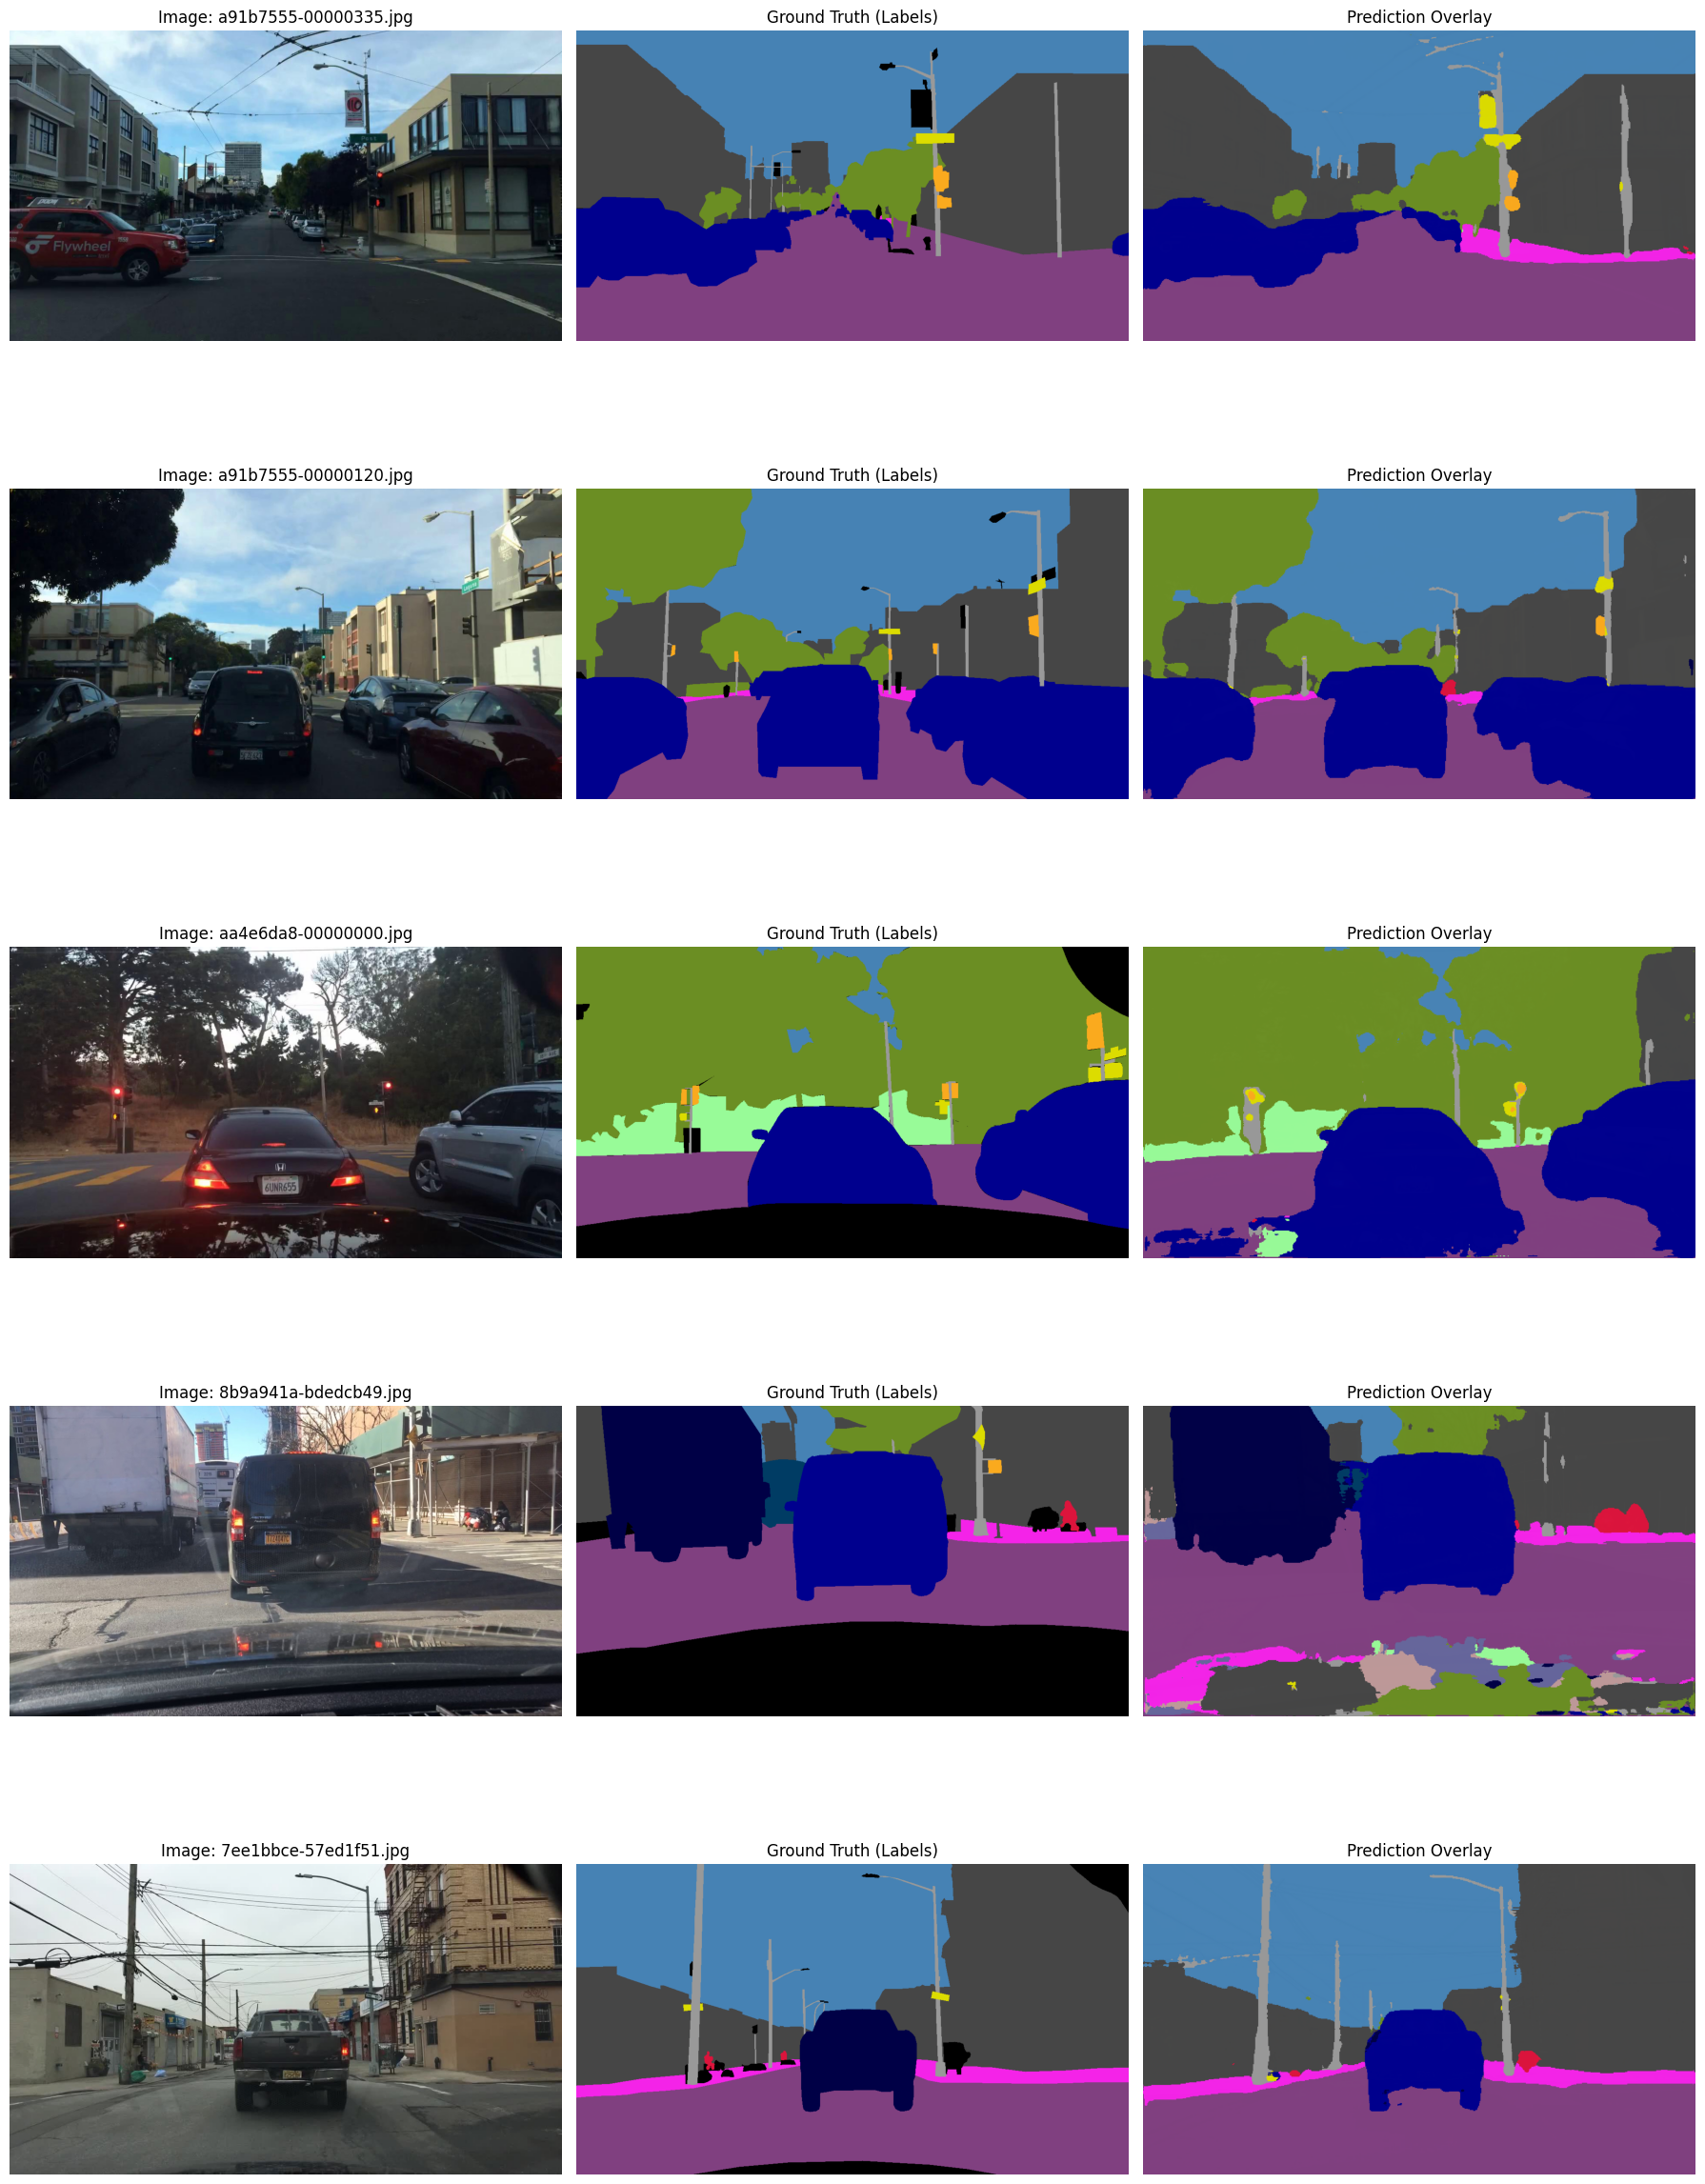

In [50]:
display_predictions(pred_dir, image_dir, color_label_dir, 5)

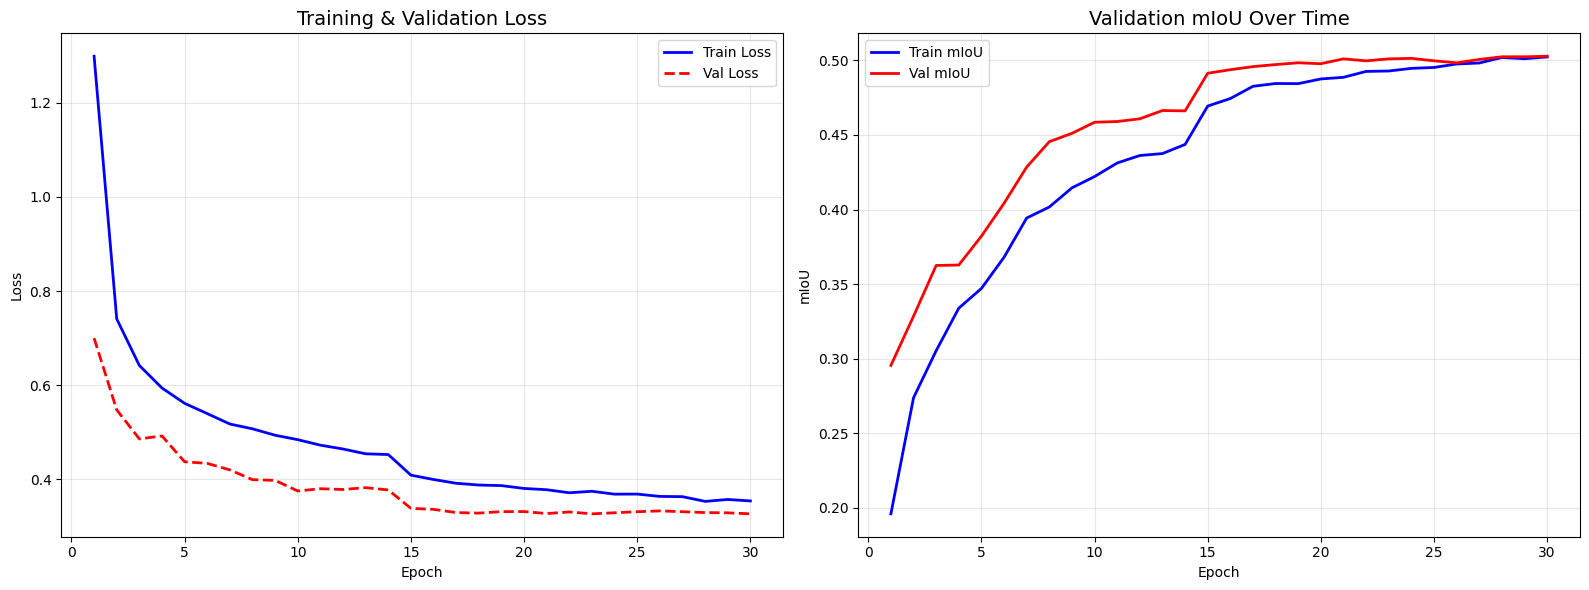

In [42]:
plot_training_logs(train_log_path)

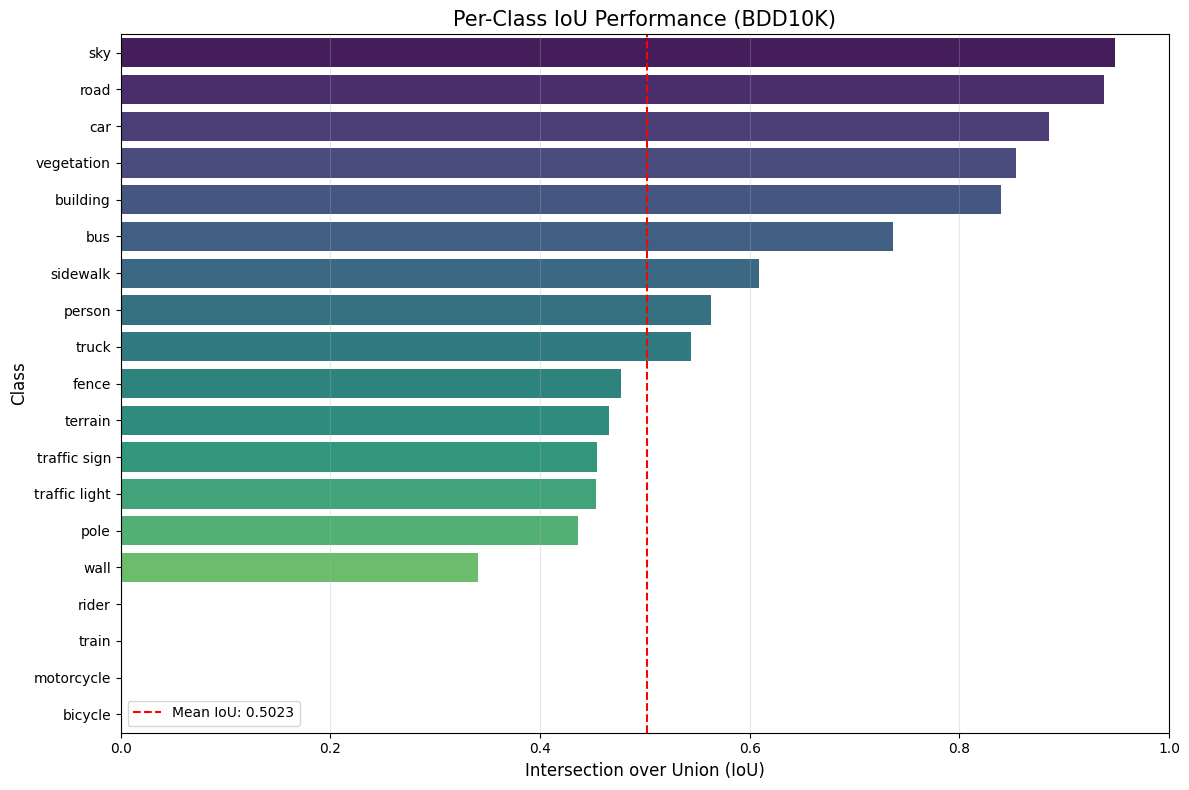

In [47]:
iou_df = plot_iou(iou_path)

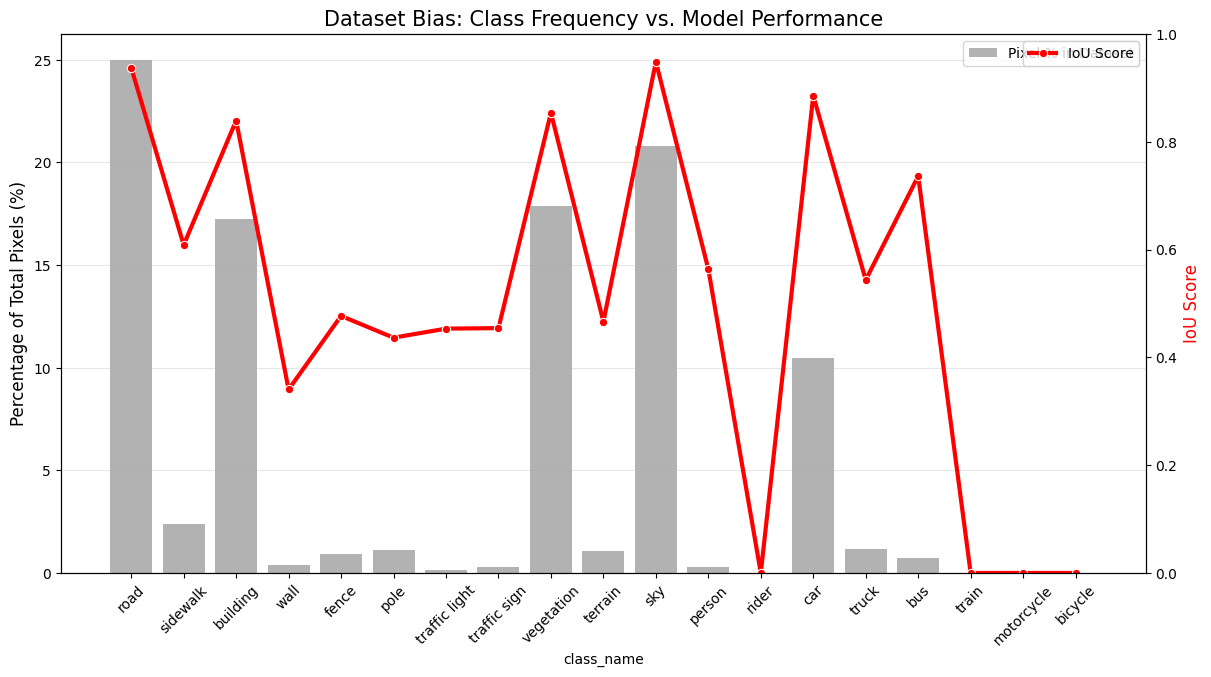

In [48]:
plot_distribution_vs_iou(dist_df, iou_df)